In [1]:
# ruff: noqa: F401, E402
import math
import sys
from bisect import bisect_left, bisect_right
from collections import Counter, deque
from functools import cmp_to_key, lru_cache, reduce
from heapq import heapify, heappop, heappush, heappushpop, nsmallest
from importlib import reload
from itertools import (
    accumulate,
    chain,
    combinations,
    islice,
    pairwise,
    permutations,
    product,
    starmap,
    tee,
)
from math import comb, factorial, log, sqrt
from operator import add, and_, contains, indexOf, itemgetter, neg, or_, xor
from pprint import pprint
from typing import Callable, Iterable, List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import arrays
import graphs
import lists
import mathematics
import matrix
import parsing
import search
import sequences
import sets
import strings
import trees

for m in (
    arrays,
    graphs,
    lists,
    mathematics,
    matrix,
    parsing,
    search,
    sequences,
    sets,
    strings,
    trees,
):
    reload(m)


from parsing import format_binop_expression, parse_binop_expression
from sequences import find_if
from strings import StringView, splint

print()


In [68]:

def articulation_points(adj: List[List[int]]) -> List[int]:
    "Return the articulation points for a graph defined by the `adj` list."
    # This uses single pass Tarjan's Algorithm.
    vt = [0] * len(adj)  # visited time for each node in DFS-tree order
    ct = vt[:]  # circle time for the parent/root of the whole circle
    o = []

    # Depth first search to determine the parent of each node
    # and created the DFS-tree.
    def dfs(p, n, t):
        vt[n] = ct[n] = t  # set the times
        # art - boolean indicating if `n` is an articulate point.
        # kids - number of kids reached from this node first.
        art = kids = 0
        for c in adj[n]:
            if not vt[c]:  # If the child node was not visited...
                dfs(n, c, t + 1)
                # Count the kids of this parent
                # which were not visited earlier by the DFS.
                kids += 1
                # If the child has a higher circle time,
                # that means that this node is not in its circle
                # and thus the child is connected only through this node.
                art |= ct[c] >= t
                # If the child circle time is lower than ours,
                # it has reached another node up in the DFT-tree.
                # This indicates that we are in a circle with the child.
                ct[n] = min(ct[n], ct[c])
            elif c != p:
                # If we reached another node (but the parent) higher
                # in the DFS-tree, update our circle time.
                # Use the original visited time, given that
                # the child may be in another circle.
                ct[n] = min(ct[n], vt[c])
        # Append the node if it is marked as an articulate point.
        # For the root of the DFS-tree (p == -1), we just need
        # to check if there are more than two kids (not in the same circle).
        if art if p != -1 else kids > 1:
            o.append(n)

    # Start search from the first node (== 0).
    dfs(-1, 0, 1)
    return sorted(o)


[1, 2]

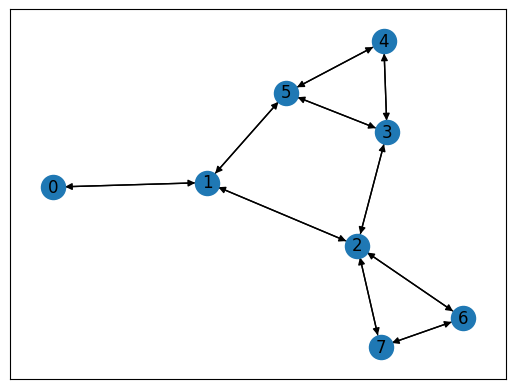

In [73]:
adj = [
    [1],
    [0, 2, 5],
    [1, 3, 6, 7],
    [2, 4, 5],
    [3, 5],
    [4, 1, 3],
    [2, 7],
    [6, 2],
]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)


[1, 2]

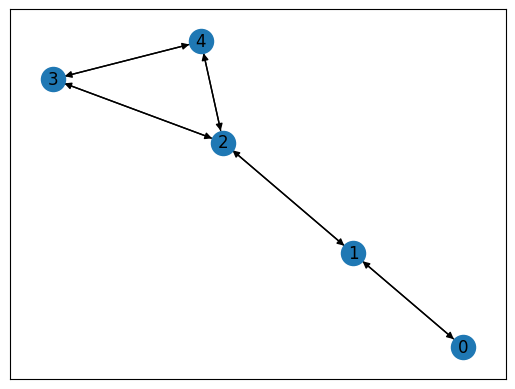

In [69]:
adj = [[1], [2, 0], [1, 3, 4], [2, 4], [2, 3]]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)


[5, 6]

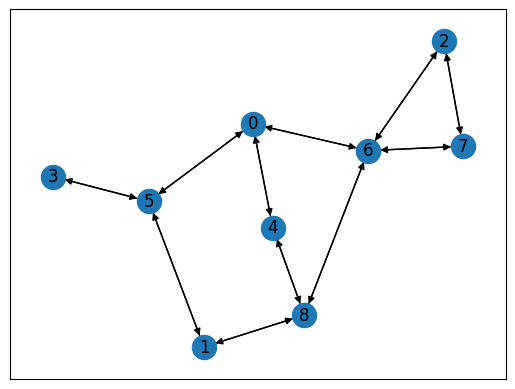

In [70]:
adj = [
    [6, 5, 4],
    [8, 5],
    [6, 7],
    [5],
    [8, 0],
    [0, 3, 1],
    [0, 8, 7, 2],
    [6, 2],
    [6, 4, 1],
]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)


[0]

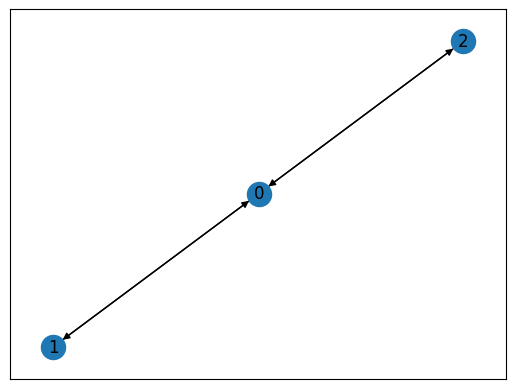

In [71]:
adj = [[1, 2], [0], [0]]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)


[2]

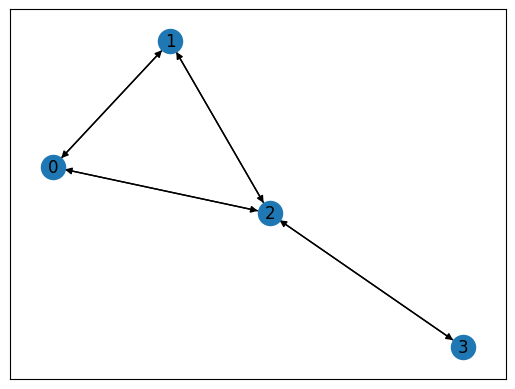

In [72]:
adj = [[1, 2], [0, 2], [0, 1, 3], [2]]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)
